# Glaucoma Detection from OCT RNFL Data in Highly Myopic Patients

This notebook presents a machine learning analysis for glaucoma detection using
OCT-derived retinal nerve fiber layer (RNFL) measurements in a highly myopic cohort.

Because clinical ground-truth labels are unavailable, glaucoma labels are derived
using myopia-aware proxy criteria based on established OCT metrics.


## 1. Imports and environment setup


In [1]:
import pandas as pd
import numpy as np



## 2. Data loading

In [2]:
# Load dataset
df = pd.read_csv("../data/raw/OCT_cleaned.csv")

## 3. Initial data inspection

In [3]:
# Basic info
print("Shape:", df.shape)
df.head()


Shape: (160, 23)


,patient_id,eye_side,eye_side_full,scan_time,scan_type,filename,global_rnfl_mean,sector_01,sector_02,sector_03,...,sector_07,sector_08,sector_09,sector_10,sector_11,sector_12,tsnit_temporal,tsnit_superior,tsnit_nasal,tsnit_inferior
0,18140,OD,Right Eye,14:56:26,Optic Disc Cube 200x200,019_RNFLProfile_OD.txt,65.791186,60.511488,73.094937,79.737191,...,56.851997,60.146935,60.040877,95.503180,69.931537,61.613985,71.804785,57.109179,58.707586,75.637154
1,18140,OG,Left Eye,11:16:19,Optic Disc Cube 200x200,019_RNFLProfile_OG.txt,78.928950,31.779391,52.502572,132.794183,...,48.652343,83.094587,114.993511,138.386290,63.492714,30.923676,71.524464,85.257220,79.926598,78.891822
2,24808,OG,Left Eye,13:22:54,Optic Disc Cube 200x200,072_RNFLProfile_OG.txt,42.659264,31.243363,27.750097,54.170454,...,33.136427,50.970928,45.356366,43.506367,38.980632,26.939347,37.837467,53.335322,42.950320,36.438606
3,49194,OD,Right Eye,16:37:02,Optic Disc Cube 200x200,009_RNFLProfile_OD.txt,66.816473,55.960747,88.000757,69.976032,...,46.229794,55.654210,60.259920,72.855745,117.272179,58.197934,72.457477,58.705609,53.700202,82.490746
4,49194,OG,Left Eye,16:37:42,Optic Disc Cube 200x200,009_RNFLProfile_OG.txt,71.676046,58.725950,80.818704,62.623544,...,47.653456,64.855940,63.445398,110.510280,92.284814,50.299011,67.377100,76.729724,58.297726,84.232463


In [4]:
df.dtypes


patient_id            int64
eye_side             object
eye_side_full        object
scan_time            object
scan_type            object
filename             object
global_rnfl_mean    float64
sector_01           float64
sector_02           float64
sector_03           float64
sector_04           float64
sector_05           float64
sector_06           float64
sector_07           float64
sector_08           float64
sector_09           float64
sector_10           float64
sector_11           float64
sector_12           float64
tsnit_temporal      float64
tsnit_superior      float64
tsnit_nasal         float64
tsnit_inferior      float64
dtype: object

In [5]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

In [6]:
df["global_rnfl_mean"].describe()


count    160.000000
mean      74.107489
std       15.034202
min       38.836814
25%       63.700564
50%       73.172688
75%       82.186485
max      126.209448
Name: global_rnfl_mean, dtype: float64

In [7]:
df[[
    "tsnit_temporal",
    "tsnit_superior",
    "tsnit_nasal",
    "tsnit_inferior"
]].describe()


,tsnit_temporal,tsnit_superior,tsnit_nasal,tsnit_inferior
count,160.000000,160.000000,160.000000,160.000000
mean,78.005096,74.482372,67.508758,76.494627
std,19.705032,15.870242,18.283777,21.082455
min,23.978020,38.208609,26.814175,31.393980
25%,64.098811,63.415285,58.326558,59.688765
50%,75.211233,72.205732,64.259237,76.846188
75%,89.514885,82.629672,74.422874,89.178096
max,131.214812,150.959613,183.868809,139.488347


In [8]:
df["eye_side_full"].value_counts()


eye_side_full
Left Eye     82
Right Eye    78
Name: count, dtype: int64

## 4. Proxy glaucoma label definition (myopia-aware)


### Proxy glaucoma label definition (OCT-based)

Because clinical glaucoma diagnoses and visual field data are unavailable,
proxy glaucoma labels are derived from OCT RNFL measurements using
established glaucoma-related criteria adapted for highly myopic eyes.

The following RNFL-based indicators are considered:
- Global RNFL thinning
- Superior RNFL thinning
- Inferior RNFL thinning
- ISNT rule violation (Inferior > Superior > Nasal > Temporal)

Eyes meeting at least **three** of these criteria are labeled as
**glaucoma suspects**.



## Define individual OCT criteria

In [9]:
# --- Metric 1: Global RNFL thinning ---
df["crit_global_rnfl"] = (df["global_rnfl_mean"] < 80).astype(int)

# --- Metric 2: Superior RNFL thinning ---
df["crit_superior_rnfl"] = (df["tsnit_superior"] < 90).astype(int)

# --- Metric 3: Inferior RNFL thinning ---
df["crit_inferior_rnfl"] = (df["tsnit_inferior"] < 90).astype(int)

# --- Metric 4: ISNT rule violation ---
df["crit_isnt_violation"] = (
    ~(
        (df["tsnit_inferior"] > df["tsnit_superior"]) &
        (df["tsnit_superior"] > df["tsnit_nasal"]) &
        (df["tsnit_nasal"] > df["tsnit_temporal"])
    )
).astype(int)

df[[
    "crit_global_rnfl",
    "crit_superior_rnfl",
    "crit_inferior_rnfl",
    "crit_isnt_violation"
]].head()


,crit_global_rnfl,crit_superior_rnfl,crit_inferior_rnfl,crit_isnt_violation
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [10]:
# Count number of positive criteria
df["criteria_sum"] = (
    df["crit_global_rnfl"] +
    df["crit_superior_rnfl"] +
    df["crit_inferior_rnfl"] +
    df["crit_isnt_violation"]
)

# Balanced proxy label: ≥ 2 criteria
df["glaucoma_proxy"] = (df["criteria_sum"] >= 2).astype(int)

df[["criteria_sum", "glaucoma_proxy"]].head()


,criteria_sum,glaucoma_proxy
0,4,1
1,4,1
2,4,1
3,4,1
4,4,1


In [11]:
label_counts = df["glaucoma_proxy"].value_counts().sort_index()
label_percent = df["glaucoma_proxy"].value_counts(normalize=True).sort_index() * 100

pd.DataFrame({
    "count": label_counts,
    "percentage": label_percent.round(2)
})


,count,percentage
glaucoma_proxy,,
0,12,7.5
1,148,92.5


In [12]:
df.groupby("glaucoma_proxy")[[
    "global_rnfl_mean",
    "tsnit_superior",
    "tsnit_inferior",
    "tsnit_nasal",
    "tsnit_temporal"
]].mean().round(2)


,global_rnfl_mean,tsnit_superior,tsnit_inferior,tsnit_nasal,tsnit_temporal
glaucoma_proxy,,,,,
0,103.44,107.59,107.00,90.49,108.75
1,71.73,71.80,74.02,65.65,75.51


### Refinement of proxy labeling criteria

An initial set of RNFL-based proxy labeling thresholds resulted in a highly
imbalanced class distribution due to the highly myopic nature of the cohort.

To mitigate over-labeling and improve class balance while preserving clinical
plausibility, the RNFL thresholds were refined and a stricter decision rule was
applied.

The final proxy labeling strategy uses:
- Myopia-adjusted RNFL thresholds
- ISNT rule violation
- A requirement of at least **three** positive criteria


In [13]:
# --- UPDATED Metric 1: Global RNFL thinning (myopia-aware) ---
df["crit_global_rnfl"] = (df["global_rnfl_mean"] < 70).astype(int)

# --- UPDATED Metric 2: Superior RNFL thinning ---
df["crit_superior_rnfl"] = (df["tsnit_superior"] < 80).astype(int)

# --- UPDATED Metric 3: Inferior RNFL thinning ---
df["crit_inferior_rnfl"] = (df["tsnit_inferior"] < 80).astype(int)

# --- Metric 4: ISNT rule violation (unchanged) ---
df["crit_isnt_violation"] = (
    ~(
        (df["tsnit_inferior"] > df["tsnit_superior"]) &
        (df["tsnit_superior"] > df["tsnit_nasal"]) &
        (df["tsnit_nasal"] > df["tsnit_temporal"])
    )
).astype(int)

# Recompute criteria sum
df["criteria_sum"] = (
    df["crit_global_rnfl"] +
    df["crit_superior_rnfl"] +
    df["crit_inferior_rnfl"] +
    df["crit_isnt_violation"]
)

# UPDATED proxy label: ≥ 3 criteria
df["glaucoma_proxy"] = (df["criteria_sum"] >= 3).astype(int)


In [14]:
df["glaucoma_proxy"].value_counts(normalize=True).round(3)


glaucoma_proxy
0    0.525
1    0.475
Name: proportion, dtype: float64

In [15]:
df.groupby("glaucoma_proxy")[[
    "global_rnfl_mean",
    "tsnit_superior",
    "tsnit_inferior",
    "tsnit_nasal",
    "tsnit_temporal"
]].mean().round(2)


,global_rnfl_mean,tsnit_superior,tsnit_inferior,tsnit_nasal,tsnit_temporal
glaucoma_proxy,,,,,
0,84.53,83.21,90.56,75.38,89.06
1,62.59,64.84,60.95,58.81,65.79


## 5. Feature selection and preprocessing


In [16]:
# Define feature columns
rnfl_features = (
    ["global_rnfl_mean"] +
    [f"sector_{i:02d}" for i in range(1, 13)] +
    [
        "tsnit_temporal",
        "tsnit_superior",
        "tsnit_nasal",
        "tsnit_inferior"
    ]
)

X = df[rnfl_features]
y = df["glaucoma_proxy"]

X.shape, y.shape


((160, 17), (160,))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((120, 17), (40, 17))

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                                     #Scaling for LogisticREG and SVM
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6. Logistic regression baseline model
Logistic regression is used as an interpretable baseline model to assess
linear separability and feature importance.


In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

logreg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [20]:
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]


In [21]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.925
ROC AUC: 0.9699248120300752

Classification report:

              precision    recall  f1-score   support

           0      0.950     0.905     0.927        21
           1      0.900     0.947     0.923        19

    accuracy                          0.925        40
   macro avg      0.925     0.926     0.925        40
weighted avg      0.926     0.925     0.925        40



In [22]:
confusion_matrix(y_test, y_pred)


array([[19,  2],
       [ 1, 18]])

In [23]:
#Interpret coefficients
coef_df = pd.DataFrame({
    "feature": rnfl_features,
    "coefficient": logreg.coef_[0]
}).sort_values(by="coefficient")

coef_df


,feature,coefficient
16,tsnit_inferior,-1.014399
10,sector_10,-0.995595
14,tsnit_superior,-0.804832
0,global_rnfl_mean,-0.755401
3,sector_03,-0.746671
11,sector_11,-0.746131
5,sector_05,-0.734641
4,sector_04,-0.686286
2,sector_02,-0.536949
12,sector_12,-0.498972


In [24]:
coef_df.sort_values(by="coefficient").head(8)


,feature,coefficient
16,tsnit_inferior,-1.014399
10,sector_10,-0.995595
14,tsnit_superior,-0.804832
0,global_rnfl_mean,-0.755401
3,sector_03,-0.746671
11,sector_11,-0.746131
5,sector_05,-0.734641
4,sector_04,-0.686286


## 7. Random Forest model
A Random Forest classifier is used to capture non-linear interactions
between RNFL features.


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [26]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_rf, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.875
ROC AUC: 0.9824561403508772

Classification report:

              precision    recall  f1-score   support

           0      0.864     0.905     0.884        21
           1      0.889     0.842     0.865        19

    accuracy                          0.875        40
   macro avg      0.876     0.873     0.874        40
weighted avg      0.876     0.875     0.875        40


Confusion matrix:
 [[19  2]
 [ 3 16]]


In [27]:
importances = pd.DataFrame({
    "feature": rnfl_features,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(10)


,feature,importance
0,global_rnfl_mean,0.265669
16,tsnit_inferior,0.192951
10,sector_10,0.132246
14,tsnit_superior,0.084756
11,sector_11,0.046570
13,tsnit_temporal,0.042974
4,sector_04,0.042593
3,sector_03,0.040296
2,sector_02,0.025258
8,sector_08,0.024120


## 8. Support Vector Machine (RBF kernel)
A Support Vector Machine with an RBF kernel is evaluated due to its
effectiveness in high-dimensional feature spaces.


In [28]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [29]:
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svm))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_svm, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_svm))


Accuracy: 0.85
ROC AUC: 0.9448621553884712

Classification report:

              precision    recall  f1-score   support

           0      0.895     0.810     0.850        21
           1      0.810     0.895     0.850        19

    accuracy                          0.850        40
   macro avg      0.852     0.852     0.850        40
weighted avg      0.854     0.850     0.850        40


Confusion matrix:
 [[17  4]
 [ 2 17]]


In [30]:
!pip install xgboost


## 9. Boosting model(XGBoost)
A boosting-based model is evaluated to improve risk ranking and
overall discriminative performance.


In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [32]:
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy: 0.9
ROC AUC: 0.9899749373433584

Classification report:

              precision    recall  f1-score   support

           0      0.905     0.905     0.905        21
           1      0.895     0.895     0.895        19

    accuracy                          0.900        40
   macro avg      0.900     0.900     0.900        40
weighted avg      0.900     0.900     0.900        40


Confusion matrix:
 [[19  2]
 [ 2 17]]


In [33]:
xgb_importance = pd.DataFrame({
    "feature": rnfl_features,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

xgb_importance.head(10)


,feature,importance
0,global_rnfl_mean,0.341853
16,tsnit_inferior,0.109704
14,tsnit_superior,0.082674
10,sector_10,0.077315
11,sector_11,0.068137
4,sector_04,0.058911
3,sector_03,0.053691
13,tsnit_temporal,0.051332
1,sector_01,0.045169
5,sector_05,0.037646


## 10. Model comparison and visualization
Models are compared using accuracy, ROC AUC, and clinically relevant
error patterns.


In [34]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


os.makedirs("../results", exist_ok=True)
os.makedirs("../figures", exist_ok=True)

def summarize_model(name, y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Sensitivity_Recall_Pos": tp / (tp + fn) if (tp + fn) else float("nan"),
        "Specificity_Recall_Neg": tn / (tn + fp) if (tn + fp) else float("nan"),
    }

comparison_rows = [
    summarize_model("Logistic Regression", y_test, y_pred, y_proba),
    summarize_model("Random Forest", y_test, y_pred_rf, y_proba_rf),
    summarize_model("SVM (RBF)", y_test, y_pred_svm, y_proba_svm),
    summarize_model("Boosting", y_test, y_pred_xgb, y_proba_xgb),
]

comparison_df = pd.DataFrame(comparison_rows).sort_values(by="ROC_AUC", ascending=False)
comparison_df


,Model,Accuracy,ROC_AUC,TN,FP,FN,TP,Sensitivity_Recall_Pos,Specificity_Recall_Neg
3,Boosting,0.900,0.989975,19,2,2,17,0.894737,0.904762
1,Random Forest,0.875,0.982456,19,2,3,16,0.842105,0.904762
0,Logistic Regression,0.925,0.969925,19,2,1,18,0.947368,0.904762
2,SVM (RBF),0.850,0.944862,17,4,2,17,0.894737,0.809524


In [35]:
comparison_df.to_csv("../results/model_comparison.csv", index=False)
print("Saved:", "../results/model_comparison.csv")


Saved: ../results/model_comparison.csv


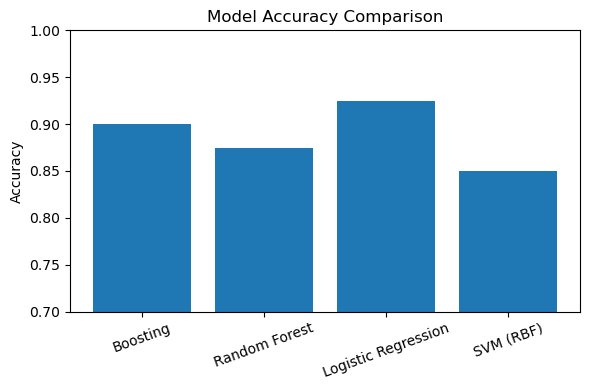

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["Accuracy"])
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig("../figures/accuracy_comparison.png", dpi=300)
plt.show()


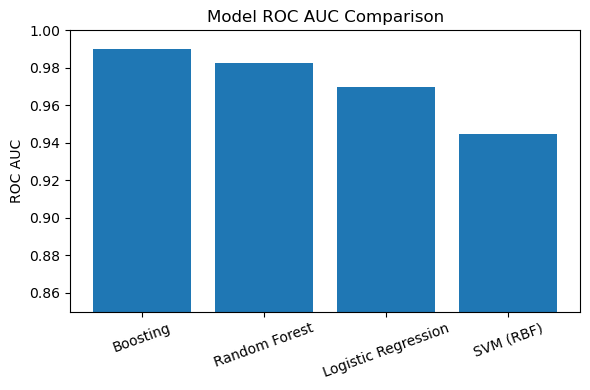

In [37]:
plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["ROC_AUC"])
plt.ylabel("ROC AUC")
plt.ylim(0.85, 1.0)
plt.title("Model ROC AUC Comparison")
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig("../figures/roc_auc_comparison.png", dpi=300)
plt.show()


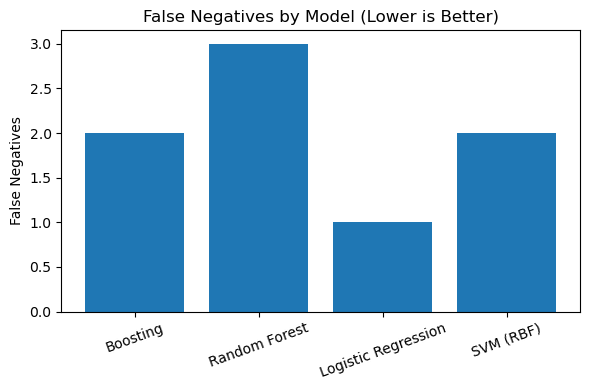

In [38]:
plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["FN"])
plt.ylabel("False Negatives")
plt.title("False Negatives by Model (Lower is Better)")
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig("../figures/false_negatives.png", dpi=300)
plt.show()


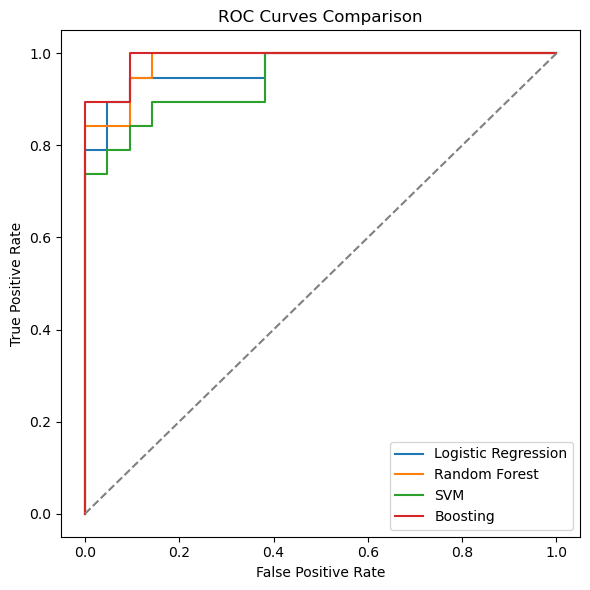

In [39]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,6))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="Logistic Regression")

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label="Random Forest")

fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr, tpr, label="SVM")

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label="Boosting")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.tight_layout()

plt.savefig("../figures/roc_curves.png", dpi=300)
plt.show()


## 11. Discussion and limitations


All evaluated models demonstrated strong discriminative performance
using OCT RNFL features despite the highly myopic nature of the cohort.
Logistic regression achieved the highest sensitivity, while ensemble
models achieved higher ROC AUC values.



From a clinical perspective, minimizing false negatives is critical
for glaucoma screening. The logistic regression model exhibited the
lowest number of false negatives, making it suitable for screening-
oriented applications.


This study is limited by the use of proxy labels instead of clinical
diagnoses, the absence of visual field data and axial length correction,
and the single-center, cross-sectional nature of the dataset.
